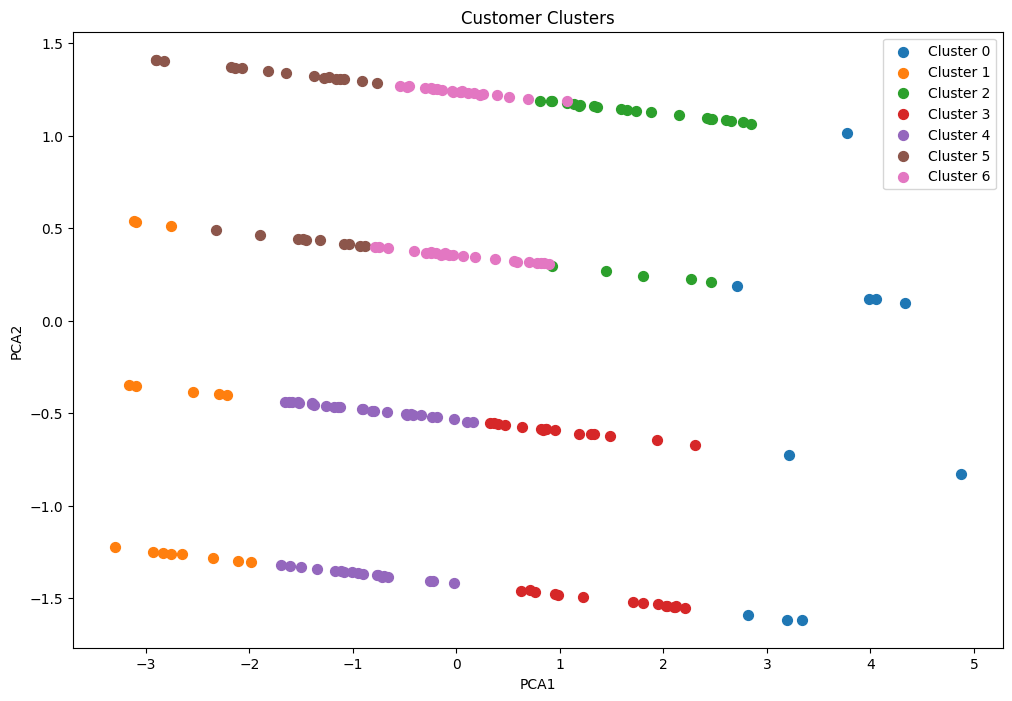

Optimal Number of Clusters: 7
Davies-Bouldin Index: 0.9198360716444208


In [4]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the datasets
customers = pd.read_csv('/content/Customers.csv')
products = pd.read_csv('/content/Products.csv')
transactions = pd.read_csv('/content/Transactions.csv')


# Merge datasets to create customer profiles
customer_profiles = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',           # Total spending
    'TransactionID': 'count',      # Number of transactions
    'Quantity': 'sum',             # Total quantity purchased
}).rename(columns={
    'TotalValue': 'TotalSpent',
    'TransactionID': 'TransactionCount',
    'Quantity': 'TotalQuantity'
})

# Add demographic information
customer_profiles = customer_profiles.merge(customers[['CustomerID', 'Region']], on='CustomerID', how='left')

# Encode Region into numerical values
customer_profiles['RegionCode'] = customer_profiles['Region'].astype('category').cat.codes

# Normalize numerical features
features = ['TotalSpent', 'TransactionCount', 'TotalQuantity', 'RegionCode']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_profiles[features])

# Perform clustering with a range of clusters (2 to 10)
cluster_results = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_data)
    db_index = davies_bouldin_score(scaled_data, labels)
    cluster_results.append({'Clusters': k, 'DB Index': db_index})

# Find the best number of clusters based on DB Index
best_result = min(cluster_results, key=lambda x: x['DB Index'])

# Re-run KMeans with the best number of clusters
optimal_k = best_result['Clusters']
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
final_labels = kmeans.fit_predict(scaled_data)

# Add cluster labels to the customer profiles
customer_profiles['Cluster'] = final_labels

# Reduce dimensions for visualization using PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
customer_profiles['PCA1'] = pca_data[:, 0]
customer_profiles['PCA2'] = pca_data[:, 1]

# Plot the clusters
plt.figure(figsize=(12, 8))
for cluster in range(optimal_k):
    subset = customer_profiles[customer_profiles['Cluster'] == cluster]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=f'Cluster {cluster}', s=50)
plt.title('Customer Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

# Save cluster results
customer_profiles.to_csv('Customer_Segments.csv', index=False)

# Report DB Index and other metrics
print(f"Optimal Number of Clusters: {optimal_k}")
print(f"Davies-Bouldin Index: {best_result['DB Index']}")
